# U.S. Patent Phrase to Phrase Matching
This is a notebook for the [U.S. Patent Phrase to Phrase Matching competition](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching) based on:
* [Jeremy Howard's notebook](https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster)
* [Nayak Roshan's notebook](https://www.kaggle.com/code/nayakroshan/uspppm-pytorch-lightning)
* [Y. Nakama's notebook](https://www.kaggle.com/code/yasufuminakama/pppm-deberta-v3-large-baseline-w-w-b-train/notebook)

In [1]:
import os
import gc
import re
import time
import math
import random
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
from scipy import stats
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification, BertForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0
tokenizers.__version__: 0.12.1
transformers.__version__: 4.18.0
env: TOKENIZERS_PARALLELISM=true


In [2]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    !pip install -q datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict
INPUT_DIR = '../input/us-patent-phrase-to-phrase-matching/'
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

## Configuration

In [3]:
class CFG:
    model_type = 'deberta' # ['bert', 'deberta']
    model_name = 'microsoft/deberta-v3-large' # ['anferico/bert-for-patents' ''../input/bert-for-patent/bert-for-patents/', 'microsoft/deberta-v3-large']
    max_len = 150
    val_size = 0.25
    seed = 42
    batch_size = 16
    num_workers = 4
    encoder_lr = 2e-5
    decoder_lr = 2e-5
    weight_decay = 0.01
    eps = 1e-6
    betas = (0.9, 0.999)
    num_cycles=0.5
    num_warmup_steps = 0
    scheduler = 'cosine' # ['linear','cosine']
    batch_scheduler = True
    fc_dropout = 0.20
    target_size = 1
    epochs = 3
    train = True
    apex = True
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    print_freq = 50
    debug = False
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [4]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=CFG.seed)

## Load Data

In [5]:
df = pd.read_csv(INPUT_DIR + '/train.csv')
test_df = pd.read_csv(INPUT_DIR + 'test.csv')
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
display(df.head())
print(f"df.shape: {df.shape}")
display(test_df.head())
print(f"test_df.shape: {test_df.shape}")
display(submission.head())
print(f"submission.shape: {submission.shape}")

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


df.shape: (36473, 5)


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


test_df.shape: (36, 4)


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


submission.shape: (36, 2)


In [6]:
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('../input/cpc-data/CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'../input/cpc-data/CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results

cpc_texts = get_cpc_texts()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
df['context_text'] = df['context'].map(cpc_texts)
test_df['context_text'] = test_df['context'].map(cpc_texts)
display(df.head())
display(test_df.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [7]:
display(df['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

## Tokenization

Create the tokenizer. Let's see what special tokens it uses.

In [8]:
tokz = AutoTokenizer.from_pretrained(CFG.model_name)
tokz.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokz
print(tokz.all_special_tokens)
sep = tokz.sep_token
print(sep)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/580 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']
[SEP]


In [9]:
df['inputs'] = df.anchor + sep + df.target + sep + df.context_text
test_df['inputs'] = test_df.anchor + sep + test_df.target + sep + test_df.context_text
display(df.head())
display(test_df.head())

,id,anchor,target,context,score,context_text,inputs
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]abatement of pollution[SEP]HUMAN...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]act of abating[SEP]HUMAN NECESSI...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]active catalyst[SEP]HUMAN NECESS...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]eliminating process[SEP]HUMAN NE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,abatement[SEP]forest region[SEP]HUMAN NECESSIT...


,id,anchor,target,context,context_text,inputs
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,opc drum[SEP]inorganic photoconductor drum[SEP...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,adjust gas flow[SEP]altering gas flow[SEP]MECH...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,lower trunnion[SEP]lower locating[SEP]PERFORMI...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,cap component[SEP]upper portion[SEP]TEXTILES; ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,neural stimulation[SEP]artificial neural netwo...


In [10]:
ds = Dataset.from_pandas(df).rename_column('score','label')
test_ds = Dataset.from_pandas(test_df)

In [11]:
display(ds[0])

{'id': '37d61fd2272659b1',
 'anchor': 'abatement',
 'target': 'abatement of pollution',
 'context': 'A47',
 'label': 0.5,
 'context_text': 'HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL',
 'inputs': 'abatement[SEP]abatement of pollution[SEP]HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLES OR APPLIANCES; COFFEE MILLS; SPICE MILLS; SUCTION CLEANERS IN GENERAL'}

Determine the longest observed length of an input. Make sure that our `max_len` is greater than this since the competition dataset may have larger inputs.

In [12]:
lengths = []
tk0 = tqdm(df['inputs'], total=len(df))
for text in tk0:
    length = len(tokz(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
print(f"longest input: {max(lengths)}\nMake sure max_len is larger than this.")

  0%|          | 0/36473 [00:00<?, ?it/s]

longest input: 99
Make sure max_len is larger than this.


## Create Validation Set
According to [this post](https://www.kaggle.com/competitions/us-patent-phrase-to-phrase-matching/discussion/315220), the private test anchors do not overlap with the training set, so we will replicate that when creating our validation set.

In [13]:
if CFG.debug:
    display(len(df))
    df = df.sample(n=1000, random_state=0).reset_index(drop=True)
    display(len(df))

In [14]:
anchors = df.anchor.unique()
np.random.seed(CFG.seed)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)

We choose some proportion of the anchors to go into the validation set:

In [15]:
val_size = CFG.val_size
val_sz = int(len(anchors)*val_size)
val_anchors = anchors[:val_sz]

Create a list of the rows that match our `val_anchors`:

In [16]:
is_val = np.isin(df.anchor, val_anchors)
idxs = np.arange(len(df))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

(9116, 27357)

## Build Datasets

In [17]:
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs

class TrainDataset(Dataset):
    def __init__(self, cfg, ds):
        self.cfg = cfg
        self.inputs = ds['inputs']
        self.labels = ds['label']

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.inputs[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label
    
class TestDataset(Dataset):
    def __init__(self, cfg, ds):
        self.cfg = cfg
        self.inputs = ds['inputs']
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.inputs[item])
        return inputs

In [18]:
#prepare_input(CFG, ds['inputs'][0])

In [19]:
trn_ds = TrainDataset(CFG,ds[trn_idxs])
val_df = ds[val_idxs]
val_labels = val_df['label']
val_ds = TrainDataset(CFG,val_df)

In [20]:
print(f'len(trn_ds): {len(trn_ds)}')
print(f'len(val_ds): {len(val_ds)}')

len(trn_ds): 27357
len(val_ds): 9116


In [21]:
print(trn_ds[0])

({'input_ids': tensor([     1,  47284,      2,  47284,    265,   6435,      2,  54373,  24817,
         37360,  50787,    260, 114347,    346,  34093,  17808,  12713,  66582,
           430,   3516,  24093,  58629, 110304,    346,  94252, 108812,    346,
        104775, 108812,    346,  20143, 100168,  46465,  12921,   3078,  43799,
             2,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,  

## Build DataLoaders

In [22]:
trn_loader = DataLoader(trn_ds,
                       batch_size=CFG.batch_size, shuffle=True,
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds,
                       batch_size=CFG.batch_size, shuffle=False, 
                        num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

## Build Model

In [23]:
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model_name, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if CFG.model_type == 'deberta':
            if pretrained:
                self.model = AutoModel.from_pretrained(cfg.model_name, config=self.config)
            else:
                self.model = AutoModel.from_config(self.config)
            self.fc_dropout = nn.Dropout(cfg.fc_dropout)
            self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
            self._init_weights(self.fc)
            self.attention = nn.Sequential(
                nn.Linear(self.config.hidden_size, 512),
                nn.Tanh(),
                nn.Linear(512, 1),
                nn.Softmax(dim=1)
            )
            self._init_weights(self.attention)
        elif CFG.model_type == 'bert':
            self.model = AutoModel.from_pretrained(CFG.model_name, config=self.config)
            self.head = nn.Linear(self.config.hidden_size, 1, bias=True)
            self.dropout = nn.Dropout(0.5)
        print(f'hidden size: {self.config.hidden_size}')
            
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)

    def forward(self, inputs):
        if CFG.model_type == 'deberta':
            outputs = self.model(**inputs)
            last_hidden_states = outputs[0]
            # feature = torch.mean(last_hidden_states, 1)
            weights = self.attention(last_hidden_states)
            feats = torch.sum(weights * last_hidden_states, dim=1)
            output = self.fc(self.fc_dropout(feats))
        elif CFG.model_type == 'bert':
            feats = self.model(**inputs)
            feats = torch.sum(feats[0], 1)/feats[0].shape[1]
            feats = self.dropout(feats)
            output = self.head(feats)
        return output

In [24]:
def get_score(y_true, y_pred):
    score = stats.pearsonr(y_true, y_pred)[0]
    return score

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1,1), labels.view(-1,1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}/{1}][{2}/{3}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, CFG.epochs, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions

def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.sigmoid().to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [25]:
def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': weight_decay},
        {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
         'lr': encoder_lr, 'weight_decay': 0.0},
        {'params': [p for n, p in model.named_parameters() if "model" not in n],
         'lr': decoder_lr, 'weight_decay': 0.0}
        ]
    return optimizer_parameters

def get_scheduler(cfg, optimizer, num_train_steps):
    if cfg.scheduler == 'linear':
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps)
    elif cfg.scheduler == 'cosine':
        scheduler = get_cosine_schedule_with_warmup(
            optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles)
    return scheduler

In [26]:
model = CustomModel(CFG, config_path=None, pretrained=True)
    
torch.save(model.config, OUTPUT_DIR + 'config.pth')
model.to(device)
print('Model loaded')

Downloading:   0%|          | 0.00/833M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/deberta-v3-large were not used when initializing DebertaV2Model: ['mask_predictions.dense.weight', 'mask_predictions.dense.bias', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.dense.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'mask_predictions.classifier.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.bias', 'mask_predictions.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


hidden size: 1024
Model loaded


In [27]:
#item0 = next(iter(trn_loader))
#inp0 = item0[0]
#label0 = item0[1]
#print(inp0)
#print(label0)

In [28]:
#inp0.to(device)
#model(inp0)

In [29]:
optimizer_parameters = get_optimizer_params(model,
                                            encoder_lr=CFG.encoder_lr, 
                                            decoder_lr=CFG.decoder_lr,
                                            weight_decay=CFG.weight_decay)
optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)

num_train_steps = int(len(trn_ds) / CFG.batch_size * CFG.epochs)
scheduler = get_scheduler(CFG, optimizer, num_train_steps)

criterion = nn.BCEWithLogitsLoss(reduction="mean")

best_score = 0.

for epoch in range(CFG.epochs):
    start_time = time.time()
    
    # train
    avg_loss = train_fn(trn_loader,model,criterion,optimizer,epoch,scheduler,device)
    
    # eval
    avg_val_loss, predictions = valid_fn(val_loader, model, criterion, device)
    
    # scoring
    score = get_score(val_labels, predictions)
    
    elapsed = time.time() - start_time
    
    print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    print(f'Epoch {epoch+1} - Score: {score:.4f}')
    
    if best_score < score:
        best_score = score
        print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        torch.save({'model': model.state_dict(),
                    'predictions': predictions},
                   OUTPUT_DIR+f"{CFG.model_name.replace('/', '-')}_best.pth")
        
    preds = torch.load(OUTPUT_DIR+f"{CFG.model_name.replace('/', '-')}_best.pth", 
                             map_location=torch.device('cpu'))['predictions']

    torch.cuda.empty_cache()
    gc.collect()
    
    labels = val_labels
    score = get_score(labels, preds)
    print(f'Score: {score:<.4f}')

Epoch: [1/3][0/1709] Elapsed 0m 2s (remain 68m 56s) Loss: 0.7001(0.7001) Grad: 108972.3359  LR: 0.00002000  
Epoch: [1/3][50/1709] Elapsed 0m 54s (remain 29m 37s) Loss: 0.5790(0.6569) Grad: 83301.6406  LR: 0.00002000  
Epoch: [1/3][100/1709] Elapsed 1m 46s (remain 28m 22s) Loss: 0.6478(0.6333) Grad: 69788.8359  LR: 0.00001998  
Epoch: [1/3][150/1709] Elapsed 2m 39s (remain 27m 22s) Loss: 0.5483(0.6214) Grad: 52950.3516  LR: 0.00001996  
Epoch: [1/3][200/1709] Elapsed 3m 31s (remain 26m 26s) Loss: 0.5567(0.6113) Grad: 62215.3438  LR: 0.00001992  
Epoch: [1/3][250/1709] Elapsed 4m 23s (remain 25m 32s) Loss: 0.5947(0.6045) Grad: 219127.7344  LR: 0.00001988  
Epoch: [1/3][300/1709] Elapsed 5m 16s (remain 24m 38s) Loss: 0.6211(0.6008) Grad: 56188.1094  LR: 0.00001983  
Epoch: [1/3][350/1709] Elapsed 6m 8s (remain 23m 45s) Loss: 0.6170(0.5962) Grad: 49901.0000  LR: 0.00001977  
Epoch: [1/3][400/1709] Elapsed 7m 0s (remain 22m 52s) Loss: 0.5003(0.5947) Grad: 140681.8438  LR: 0.00001970  
Epoc

```
class CFG:
    model_name = "microsoft/deberta-v3-large"
    max_len = 128
    val_size = 0.25
    seed = 42
    batch_size = 16
    num_workers = 4
    encoder_lr = 2e-5
    decoder_lr = 2e-5
    weight_decay = 0.01
    eps = 1e-6
    betas = (0.9, 0.999)
    num_cycles=0.5
    num_warmup_steps = 0
    scheduler = 'cosine' # ['linear','cosine']
    batch_scheduler = True
    fc_dropout = 0.20
    target_size = 1
    epochs = 3
    train = True
    apex = True
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    print_freq = 100
    debug = False
```

(5/21) Score: 0.8402

```
class CFG:
    model_name = "microsoft/deberta-v3-large"
    max_len = 128
    val_size = 0.25
    seed = 42
    batch_size = 16
    num_workers = 4
    encoder_lr = 2e-5
    decoder_lr = 2e-5
    weight_decay = 0.01
    eps = 1e-6
    betas = (0.9, 0.999)
    num_cycles=0.5
    num_warmup_steps = 0
    scheduler = 'cosine' # ['linear','cosine']
    batch_scheduler = True
    fc_dropout = 0.20
    target_size = 1
    epochs = 6
    train = True
    apex = True
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    print_freq = 100
    debug = False
```

(5/22) Score: 0.8385

Just jamming in bert-for-patents without changing the model structure at all results in garbage.

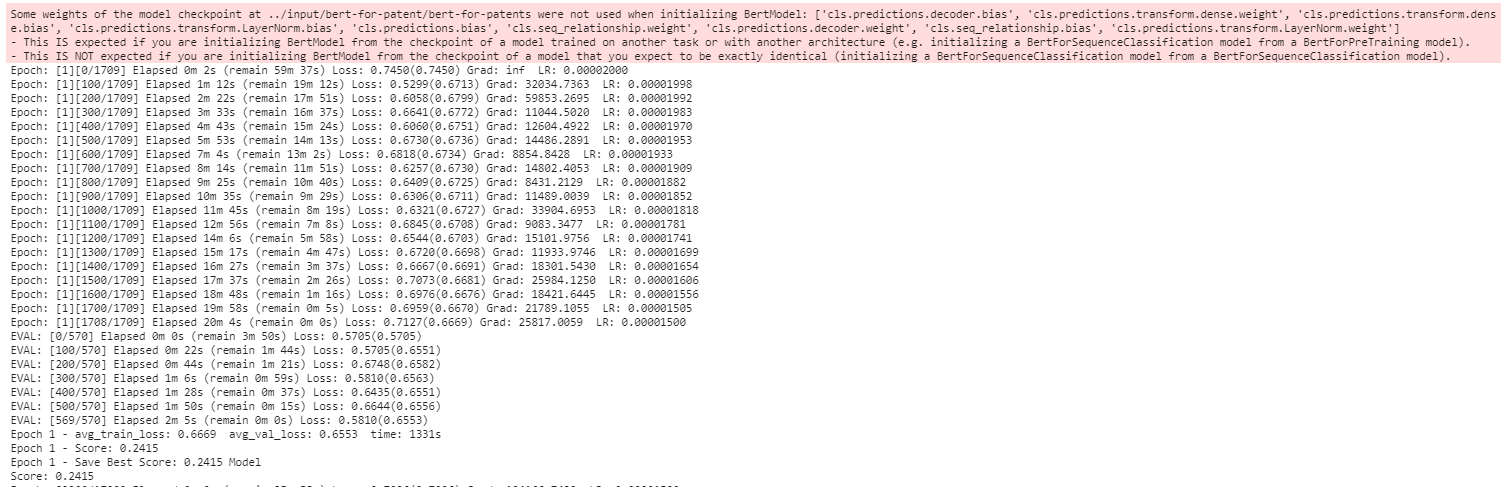

Just jamming in roberta-large doesn't work either.

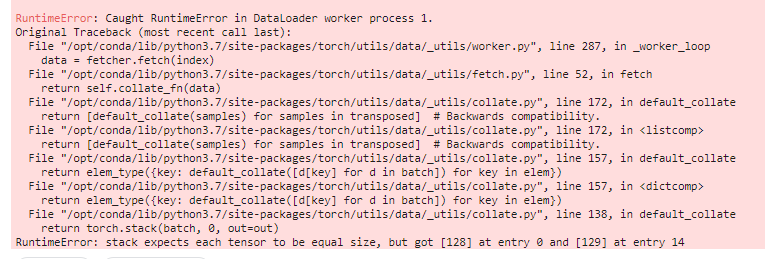

(5/31) New attempt with bert-for-patent

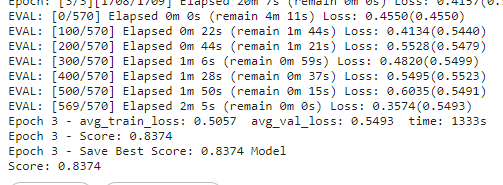

(6/1) Roberta-base:
```
class CFG:
    model_type = 'bert' # ['bert', 'deberta']
    model_name = 'roberta-base' # ['anferico/bert-for-patents' ''../input/bert-for-patent/bert-for-patents/', 'microsoft/deberta-v3-large']
    max_len = 150
    val_size = 0.25
    seed = 42
    batch_size = 16
    num_workers = 4
    encoder_lr = 2e-5
    decoder_lr = 2e-5
    weight_decay = 0.01
    eps = 1e-6
    betas = (0.9, 0.999)
    num_cycles=0.5
    num_warmup_steps = 0
    scheduler = 'cosine' # ['linear','cosine']
    batch_scheduler = True
    fc_dropout = 0.20
    target_size = 1
    epochs = 3
    train = True
    apex = True
    gradient_accumulation_steps = 1
    max_grad_norm = 1000
    print_freq = 100
    debug = False
```

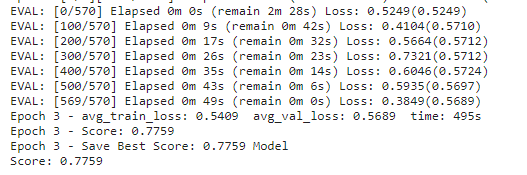

(6/1) Roberta-base with Deberta's post-layers

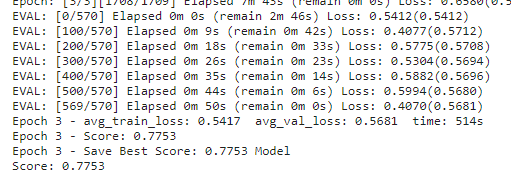

In [30]:
test_dataset = TestDataset(CFG, test_ds)
test_loader = DataLoader(test_dataset,
                         batch_size=CFG.batch_size,
                         shuffle=False,
                         num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
predictions = inference_fn(test_loader, model, device)

  0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
display(predictions)

array([[5.6182784e-01],
       [7.6891184e-01],
       [5.9751570e-01],
       [2.2569174e-01],
       [1.8517383e-04],
       [4.7342917e-01],
       [5.0178778e-01],
       [1.2349675e-04],
       [2.4082696e-01],
       [9.9935275e-01],
       [2.2509794e-01],
       [2.6385301e-01],
       [7.7413684e-01],
       [8.6054224e-01],
       [7.7479386e-01],
       [2.9719993e-01],
       [1.9775851e-01],
       [2.2712931e-04],
       [5.4280216e-01],
       [2.3928957e-01],
       [2.8498706e-01],
       [2.4356963e-01],
       [7.5295053e-02],
       [2.2094059e-01],
       [5.4607540e-01],
       [1.6030566e-04],
       [2.1591359e-04],
       [1.7559767e-04],
       [1.6339068e-04],
       [6.5781677e-01],
       [1.3861945e-03],
       [1.8533593e-03],
       [6.6778320e-01],
       [5.6865388e-01],
       [3.3628112e-01],
       [2.4910793e-01]], dtype=float32)

In [32]:
np.clip(predictions,0,1)

array([[5.6182784e-01],
       [7.6891184e-01],
       [5.9751570e-01],
       [2.2569174e-01],
       [1.8517383e-04],
       [4.7342917e-01],
       [5.0178778e-01],
       [1.2349675e-04],
       [2.4082696e-01],
       [9.9935275e-01],
       [2.2509794e-01],
       [2.6385301e-01],
       [7.7413684e-01],
       [8.6054224e-01],
       [7.7479386e-01],
       [2.9719993e-01],
       [1.9775851e-01],
       [2.2712931e-04],
       [5.4280216e-01],
       [2.3928957e-01],
       [2.8498706e-01],
       [2.4356963e-01],
       [7.5295053e-02],
       [2.2094059e-01],
       [5.4607540e-01],
       [1.6030566e-04],
       [2.1591359e-04],
       [1.7559767e-04],
       [1.6339068e-04],
       [6.5781677e-01],
       [1.3861945e-03],
       [1.8533593e-03],
       [6.6778320e-01],
       [5.6865388e-01],
       [3.3628112e-01],
       [2.4910793e-01]], dtype=float32)